## Image Clustering

#### SCAN: Learning to Classify Images without Labels

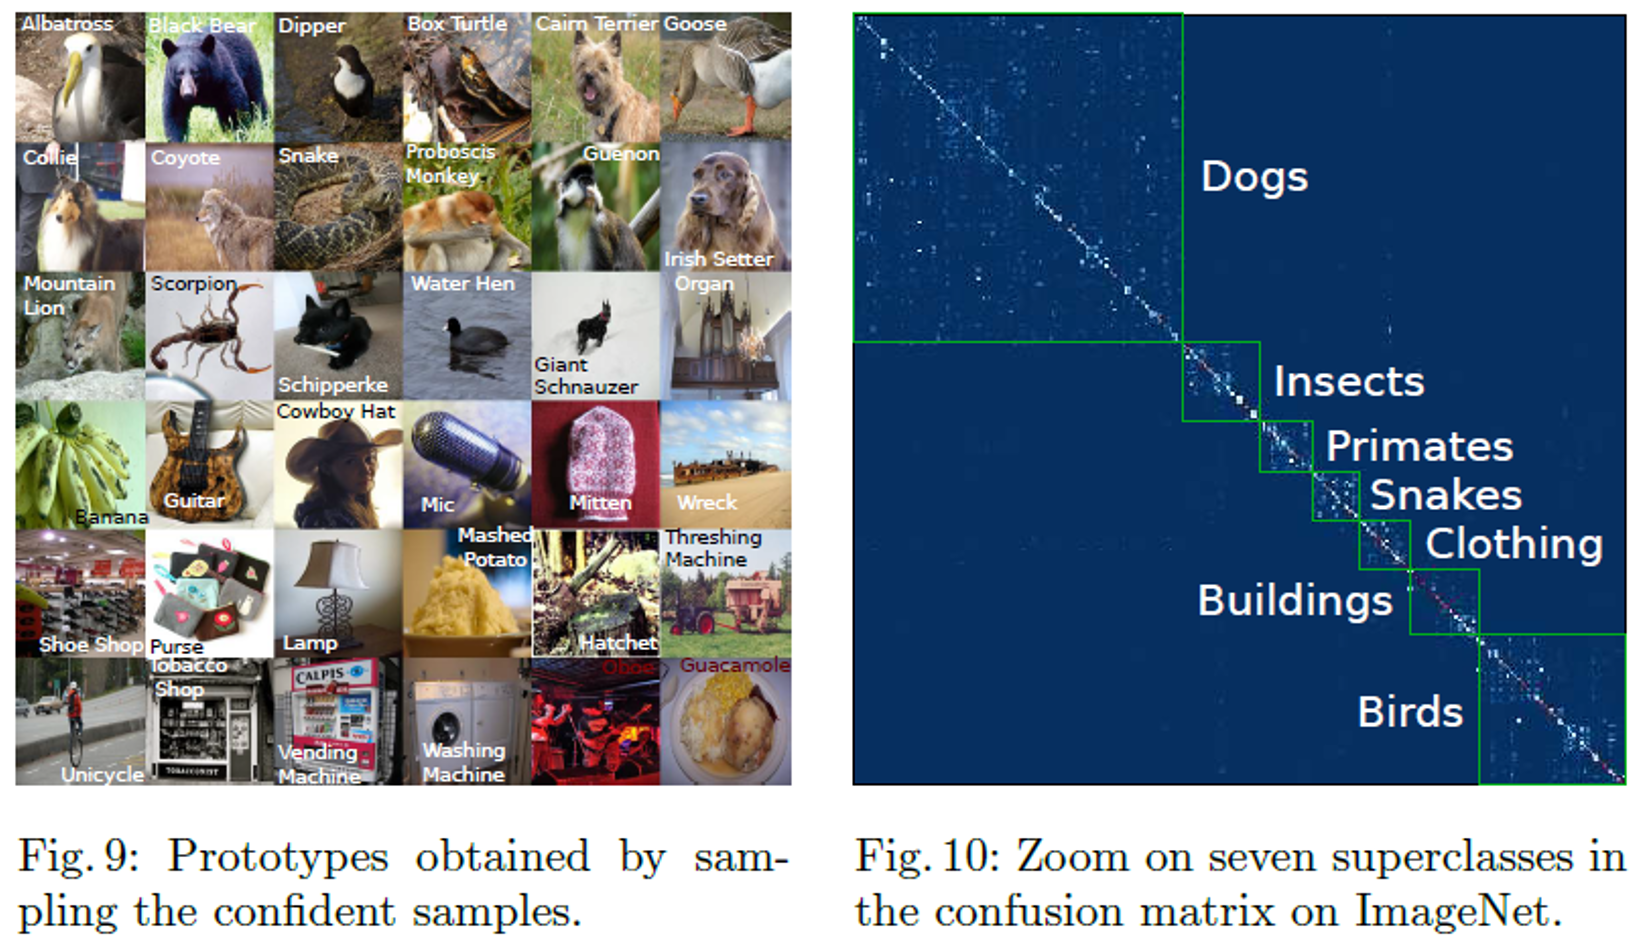

In [1]:
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, transfrom_aug):
        super(AugmentedDataset, self).__init__()
        '''
        transform : Nearest neighbor 계산을 위한 w/o augmentation setting
        transform_aumg : augmentation 용
        '''
        
        self.transform = transform
        self.transform_aug = transfrom_aug
        self.dataset = dataset
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        '''
        output['index'] : shuffle 후에도 index 정보를 가지기 위함
        output['label'] : acc 계산용, 학습에 사용하지 않음
        '''
        sample = self.dataset.__getitem__(index)
        image = sample[0]
        label = sample[1]
        output = {}
        output['image'] = self.transform(image)
        output['image_augmented'] = self.transform_aug(image)
        output['label'] = label
        output['index'] = index
        return output

In [3]:
## augmentation
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomAffine(
         degrees=0.15, 
         translate=(0.2,0.2), 
         scale=(0.97,1.01),
         interpolation=transforms.InterpolationMode.NEAREST),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512
num_classes = 10
input_shape = (32,32,3)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)
dataset = torch.utils.data.ConcatDataset([trainset, testset])
trainloader = torch.utils.data.DataLoader(AugmentedDataset(dataset, test_transform, train_transform), 
                                          batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

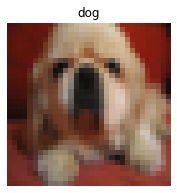

In [5]:
## augmentation하지 않은 이미지 sample
image_idx = np.random.choice(range(len(dataset)))
image = dataset[image_idx][0]
image_class = classes[dataset[image_idx][1]]
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.title(image_class)
_ = plt.axis("off")

dog


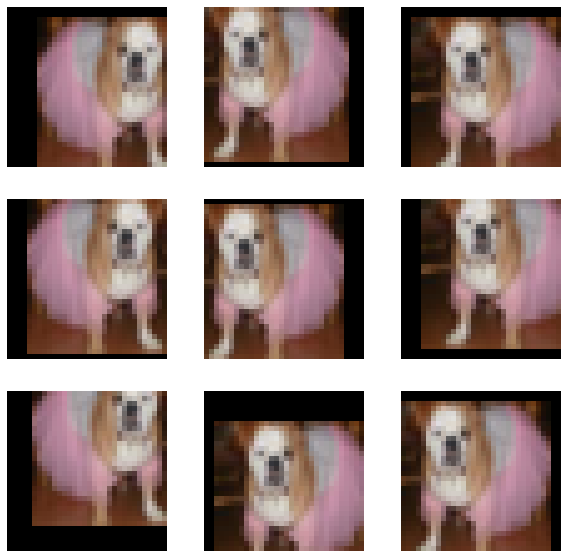

In [6]:
## augmentation한 이미지 sample
plt.figure(figsize=(10, 10))
image_idx = np.random.choice(range(len(trainloader.dataset)))
image_class = classes[trainloader.dataset[image_idx]['label']]
print(image_class)
for i in range(9):
    augmented_images = trainloader.dataset[image_idx]['image_augmented']
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((augmented_images.permute(1,2,0)*0.5+0.5).numpy())
    plt.axis("off")

In [7]:
## representation을 학습할 backbone : resnet50
## 2048은 resnet logit의 dimension
def create_encoder(representation_dim) :
    backbone = models.__dict__['resnet50']()
    backbone.fc = nn.Identity()
    encoder = nn.Sequential(
        backbone,
        nn.Linear(2048, representation_dim)
    )
    return encoder

In [8]:
class RepresentationLearner(nn.Module):
    '''
    Representation을 학습을 위한 모델
    encoder : resnet50 backbone
    projection_units : projection layer output dimension
    num_augmentation : augmentation 수(2)
    '''
    def __init__(self, encoder, projection_units, num_augmentations, dropout_rate=0.1, **kwargs):
        super(RepresentationLearner, self).__init__()
        self.encoder = encoder
        
        self.projector = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(representation_dim, projection_units, bias=False),
            nn.BatchNorm1d(projection_units),
            nn.ReLU()
        )
        
        self.num_augmentations = num_augmentations

    def forward(self, inputs):
        augmented = []
        for _ in range(self.num_augmentations) :
            augmented.append(inputs)
        augmented = torch.cat(augmented, 0)
        
        features = self.encoder(augmented)
        return self.projector(features)

In [9]:
## cosine decay learning rate scheduler
def adjust_learning_rate(optimizer, lr, decay_rate, epoch, max_epoch):
    eta_min = lr * (decay_rate ** 3)
    lr = eta_min + (lr - eta_min) * (1 + math.cos(math.pi * epoch / max_epoch)) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [10]:
lr = 1e-3
epochs = 300
decay_rate = 0.1
encoder = create_encoder(representation_dim)
representation_learner = RepresentationLearner(encoder, projection_units, num_augmentations=2) 
optimizer = torch.optim.AdamW(representation_learner.parameters(), lr=lr, weight_decay=1e-4)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)
representation_learner = representation_learner.to(device)

In [12]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [60]:
def compute_contrastive_loss(feature_vectors, num_augmentations=2, l2_normalize=False, temperature=1.0) :
    '''
    cosine similarity가 positive sample에 대해선 1이되도록 학습
    max logit을 빼면 최댓값이 1이고, 로그를 취하면 0이됨
    torch.eye(b) : bxb만큼의 identity matrix
    torch.tile : input을 axb 형태로 복사
    '''
    b = feature_vectors.shape[0] // num_augmentations
    if l2_normalize :
        feature_vectors = F.normalize(feature_vectors, dim = 1)
    
    logits = torch.matmul(feature_vectors, feature_vectors.T)/temperature
    
    logits_max, _ = torch.max(logits, 1)
    logits = logits - logits_max
    preds = nn.Softmax()(logits)
    
    targets = torch.tile(torch.eye(b), (num_augmentations,num_augmentations)).to(device)
    loss = (-(preds).log() * targets -(1-preds).log() * (1-targets)).sum(dim=1).mean()
    
    return loss

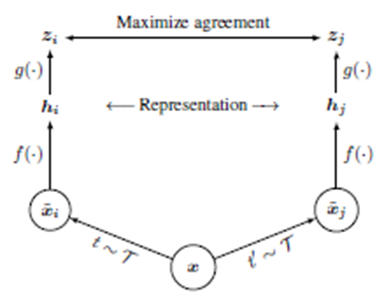

In [61]:
torch.eye(batch_size)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [62]:
torch.eye(batch_size).shape

torch.Size([512, 512])

In [63]:
torch.tile(torch.eye(batch_size), (2,2)).shape

torch.Size([1024, 1024])

In [64]:
## Self-supervised learning
loss_history = []
for epoch in range(50) :
    lr = adjust_learning_rate(optimizer, lr, decay_rate, epoch, epochs)
    representation_learner.train()
    loss_tracker = AverageMeter()
    
    for i, train_iter in enumerate(trainloader) :
        train_img = train_iter['image_augmented']
        train_img = train_img.to(device)
        
        train_feature = representation_learner(train_img)
        loss = compute_contrastive_loss(train_feature, 2, l2_normalize=True, temperature=0.1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_tracker.update(np.mean(loss.item()))
    print('Epoch: [{0}]\t'
          'LR: {lr:.4f}\t'
          'train_loss: {loss_tracker.val:.4f} ({loss_tracker.avg:.4f})\t'
          .format(epoch, lr=optimizer.param_groups[0]['lr'],
                  loss_tracker=loss_tracker))
    loss_history.append(loss_tracker.avg)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoch: [0]	LR: 0.0000	train_loss: 1.4620 (1.6933)	
Epoch: [1]	LR: 0.0000	train_loss: 1.4616 (1.6929)	
Epoch: [2]	LR: 0.0000	train_loss: 1.4571 (1.6919)	
Epoch: [3]	LR: 0.0000	train_loss: 1.4616 (1.6917)	
Epoch: [4]	LR: 0.0000	train_loss: 1.4681 (1.6924)	
Epoch: [5]	LR: 0.0000	train_loss: 1.4613 (1.6922)	
Epoch: [6]	LR: 0.0000	train_loss: 1.4531 (1.6931)	
Epoch: [7]	LR: 0.0000	train_loss: 1.4623 (1.6928)	
Epoch: [8]	LR: 0.0000	train_loss: 1.4595 (1.6926)	
Epoch: [9]	LR: 0.0000	train_loss: 1.4751 (1.6922)	
Epoch: [10]	LR: 0.0000	train_loss: 1.4661 (1.6924)	
Epoch: [11]	LR: 0.0000	train_loss: 1.4645 (1.6913)	
Epoch: [12]	LR: 0.0000	train_loss: 1.4847 (1.6934)	
Epoch: [13]	LR: 0.0000	train_loss: 1.4567 (1.6928)	
Epoch: [14]	LR: 0.0000	train_loss: 1.4589 (1.6921)	
Epoch: [15]	LR: 0.0000	train_loss: 1.4746 (1.6930)	
Epoch: [16]	LR: 0.0000	train_loss: 1.4611 (1.6921)	
Epoch: [17]	LR: 0.0000	train_loss: 1.4671 (1.6936)	
Epoch: [18]	LR: 0.0000	train_loss: 1.4651 (1.6924)	
Epoch: [19]	LR: 0.0000

In [65]:
torch.save(representation_learner.state_dict(), 'representation_model.pt')
# representation_learner.load_state_dict(torch.load('representation_model.pt'))

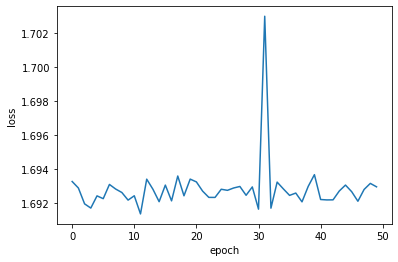

In [66]:
plt.plot(loss_history)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [67]:
representation_learner.eval()
with torch.no_grad() :
    val_features = []
    val_indices = []
    for val_iter in tqdm(trainloader) :
        val_img = val_iter['image']
        val_img = val_img.to(device)
        
        val_idx = val_iter['index']
        val_indices.append(val_idx)
        
        val_feature = encoder(val_img)
        val_feature = F.normalize(val_feature, dim = 1)
        val_features.append(val_feature)
    val_features = torch.cat(val_features, 0)
    val_indices = torch.cat(val_indices, 0)

100%|██████████| 118/118 [01:43<00:00,  1.14it/s]


In [68]:
num_batches = val_features.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches+1)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = val_features[start_idx:end_idx]
    
    similarities = torch.matmul(current_batch, val_features.T)
    _, indices = torch.topk(similarities, k=k_neighbours + 1, sorted=True)
    
    # indices = indices[..., :].cpu()
    if batch_idx == 0 :
        neighbours = indices[..., :].cpu()
    else :
        neighbours = torch.cat([neighbours,indices[..., :].cpu()], dim=0)

100%|██████████| 118/118 [00:00<00:00, 166.03it/s]


In [69]:
neighbours_idx = np.zeros_like(neighbours[:,1:])
for idx in range(len(neighbours)) :
    neighbours_idx[val_indices[neighbours[idx][0]]] = val_indices[neighbours[idx][1:]]

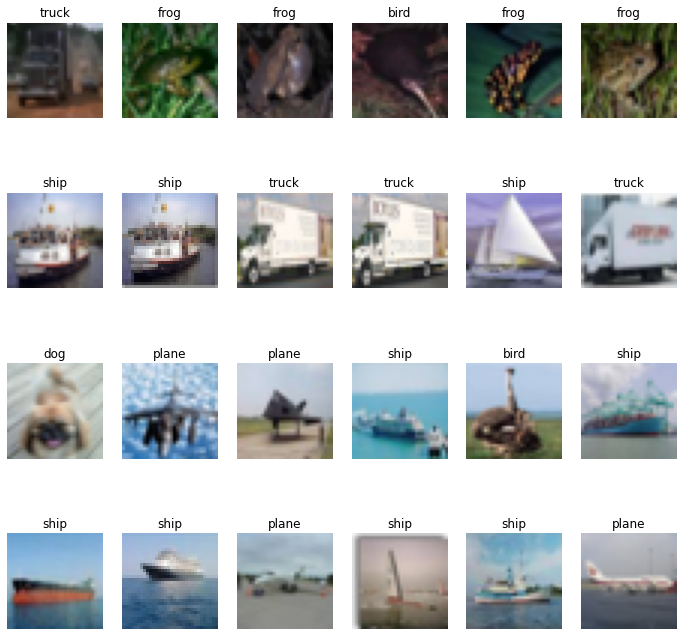

In [100]:
## representation 이 가까운 이미지 확인
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(len(trainloader.dataset)))
    indices = [anchor_idx] + neighbours_idx[anchor_idx].tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        img = trainloader.dataset[indices[j]]['image']
        label = trainloader.dataset[indices[j]]['label']
        plt.imshow(img.permute(1,2,0)*0.5+0.5)
        plt.title(classes[label])
        plt.axis("off")
        position += 1

In [72]:
## Nearest neighbor dataset 
## Neighbor data도 같이 laod할 수 있도록 dataset 정의
class NeighborsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, transfrom_aug, indices):
        super(NeighborsDataset, self).__init__()
        self.transform = transform
        self.transform_aug = transfrom_aug
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        sample = self.dataset.__getitem__(index)
        image = sample[0]
        label = sample[1]
        output = {}
        output['image'] = self.transform(image)
        output['image_augmented'] = self.transform_aug(image)
        output['label'] = label
        output['index'] = index
        
        neighbours_idx = self.indices[index]
        neighbours = [self.dataset.__getitem__(x) for x in neighbours_idx]
        output['neighbours'] = [self.transform_aug(x[0]) for x in neighbours]
        
        return output
    
trainloader = torch.utils.data.DataLoader(NeighborsDataset(dataset, test_transform, 
                                                           train_transform, neighbours_idx), 
                                          batch_size=batch_size, shuffle=True)

In [73]:
## Clustering model 정의
class ClusteringLearner(nn.Module):
    def __init__(self, encoder, num_clusters):
        super(ClusteringLearner, self).__init__()
        self.encoder = encoder
        
        self.num_clusters = num_clusters
        self.cluster_head = nn.Linear(representation_dim, num_clusters)
        self.activation = nn.Softmax(dim=-1)

    def forward(self, inputs, include_neighbor=False, tune_encoder=False):
        inputs['image'] = inputs['image'].cuda()
        features = self.encoder(inputs['image'])
        if not tune_encoder :
            features = features.detach()
        anchor_clustering = self.cluster_head(features)
        anchor_clustering = self.activation(anchor_clustering)
        
        if include_neighbor :
            neighbours = torch.cat(inputs['neighbours'],0)
            neighbours = neighbours.cuda()
            neighbor_features = self.encoder(neighbours)
            if not tune_encoder :
                neighbor_features = neighbor_features.detach()
            neighbor_clustering = self.cluster_head(neighbor_features)
            neighbor_clustering = self.activation(neighbor_clustering)
            neighbor_clustering = neighbor_clustering.view(-1, k_neighbours, self.num_clusters)
            
            similarity = torch.einsum('bij,bkj->bik', anchor_clustering.unsqueeze(1), neighbor_clustering)
            similarity = similarity.squeeze(1)
            return anchor_clustering, neighbor_clustering, similarity
        else :
            return anchor_clustering

In [79]:
clustering_learner = ClusteringLearner(encoder, num_clusters)
clustering_learner = clustering_learner.to(device)

In [80]:
## Clustering loss 계산
def compute_ClustersConsistencyLoss(target, similarity) :
    target = torch.ones_like(similarity)
    
    loss = (-(similarity).log() * target).sum(dim=1).mean()
    return loss

In [81]:
## Entropy loss 계산
def compute_ClustersEntropyLoss(target, cluster_probabilities, entropy_loss_weight=1.0) :
    num_clusters = torch.tensor(cluster_probabilities.size(-1)).type(torch.float)
    target = num_clusters.log()
    
    cluster_probabilities = torch.mean(cluster_probabilities, 0)
    cluster_probabilities = torch.clip(cluster_probabilities, 1e-8, 1.0)
    
    entropy = -torch.sum(cluster_probabilities * cluster_probabilities.log())
    
    loss = target - entropy
    return entropy_loss_weight*loss

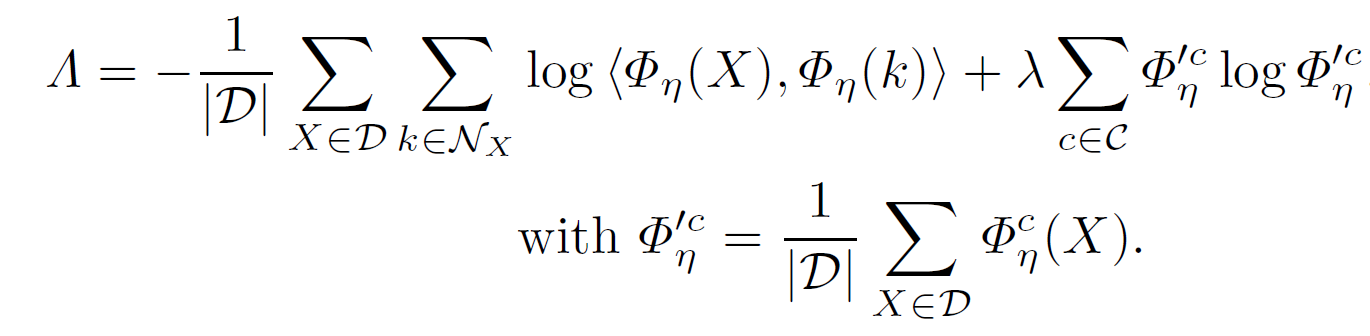

In [82]:
optimizer = torch.optim.AdamW(clustering_learner.parameters(), lr=5e-4, weight_decay=1e-4)

In [ ]:
## Clustering model 학습
loss_history2 = []
for epoch in range(50) :
    clustering_learner.train()
    loss_tracker = AverageMeter()
    
    for i, train_iter in enumerate(trainloader) :
        
        anchor_clustering, neighbor_clustering, similarity = clustering_learner(
            train_iter, include_neighbor=True, tune_encoder=False)
        labels = torch.ones(train_iter['label'].shape[0])
        loss1 = compute_ClustersConsistencyLoss(labels, similarity)
        loss2 = compute_ClustersEntropyLoss(labels, anchor_clustering, entropy_loss_weight=5)
        loss = loss1+loss2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_tracker.update(np.mean(loss.item()))
    print('Epoch: [{0}]\t'
          'train_loss: {loss_tracker.val:.4f} ({loss_tracker.avg:.4f})\t'
          .format(epoch,loss_tracker=loss_tracker))
    loss_history2.append(loss_tracker.avg)

Epoch: [0]	train_loss: 11.0193 (12.6098)	
Epoch: [1]	train_loss: 10.4185 (10.4011)	
Epoch: [2]	train_loss: 10.3522 (10.1666)	
Epoch: [3]	train_loss: 10.8138 (10.0830)	


In [ ]:
torch.save(clustering_learner.state_dict(), 'clustering_model.pt')

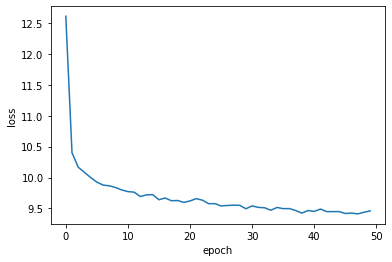

In [90]:
plt.plot(loss_history2)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [91]:
clustering_learner.eval()
with torch.no_grad() :
    clustering_probs = []
    for val_iter in tqdm(trainloader) :
        clustering_prob = clustering_learner(val_iter)
        
        clustering_probs.append(clustering_prob)
    clustering_probs = torch.cat(clustering_probs, 0)
    cluster_assignments = torch.argmax(clustering_probs, dim=-1).cpu().numpy()
    cluster_confidence, _ = torch.max(clustering_probs, dim=-1)

100%|██████████| 118/118 [01:44<00:00,  1.12it/s]


In [92]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 335
cluster 1 : 480
cluster 2 : 457
cluster 3 : 489
cluster 4 : 435
cluster 5 : 269
cluster 6 : 532
cluster 7 : 887
cluster 8 : 311
cluster 9 : 273
cluster 10 : 422
cluster 11 : 549
cluster 12 : 50494
cluster 13 : 418
cluster 14 : 505
cluster 15 : 514
cluster 16 : 555
cluster 17 : 987
cluster 18 : 475
cluster 19 : 613


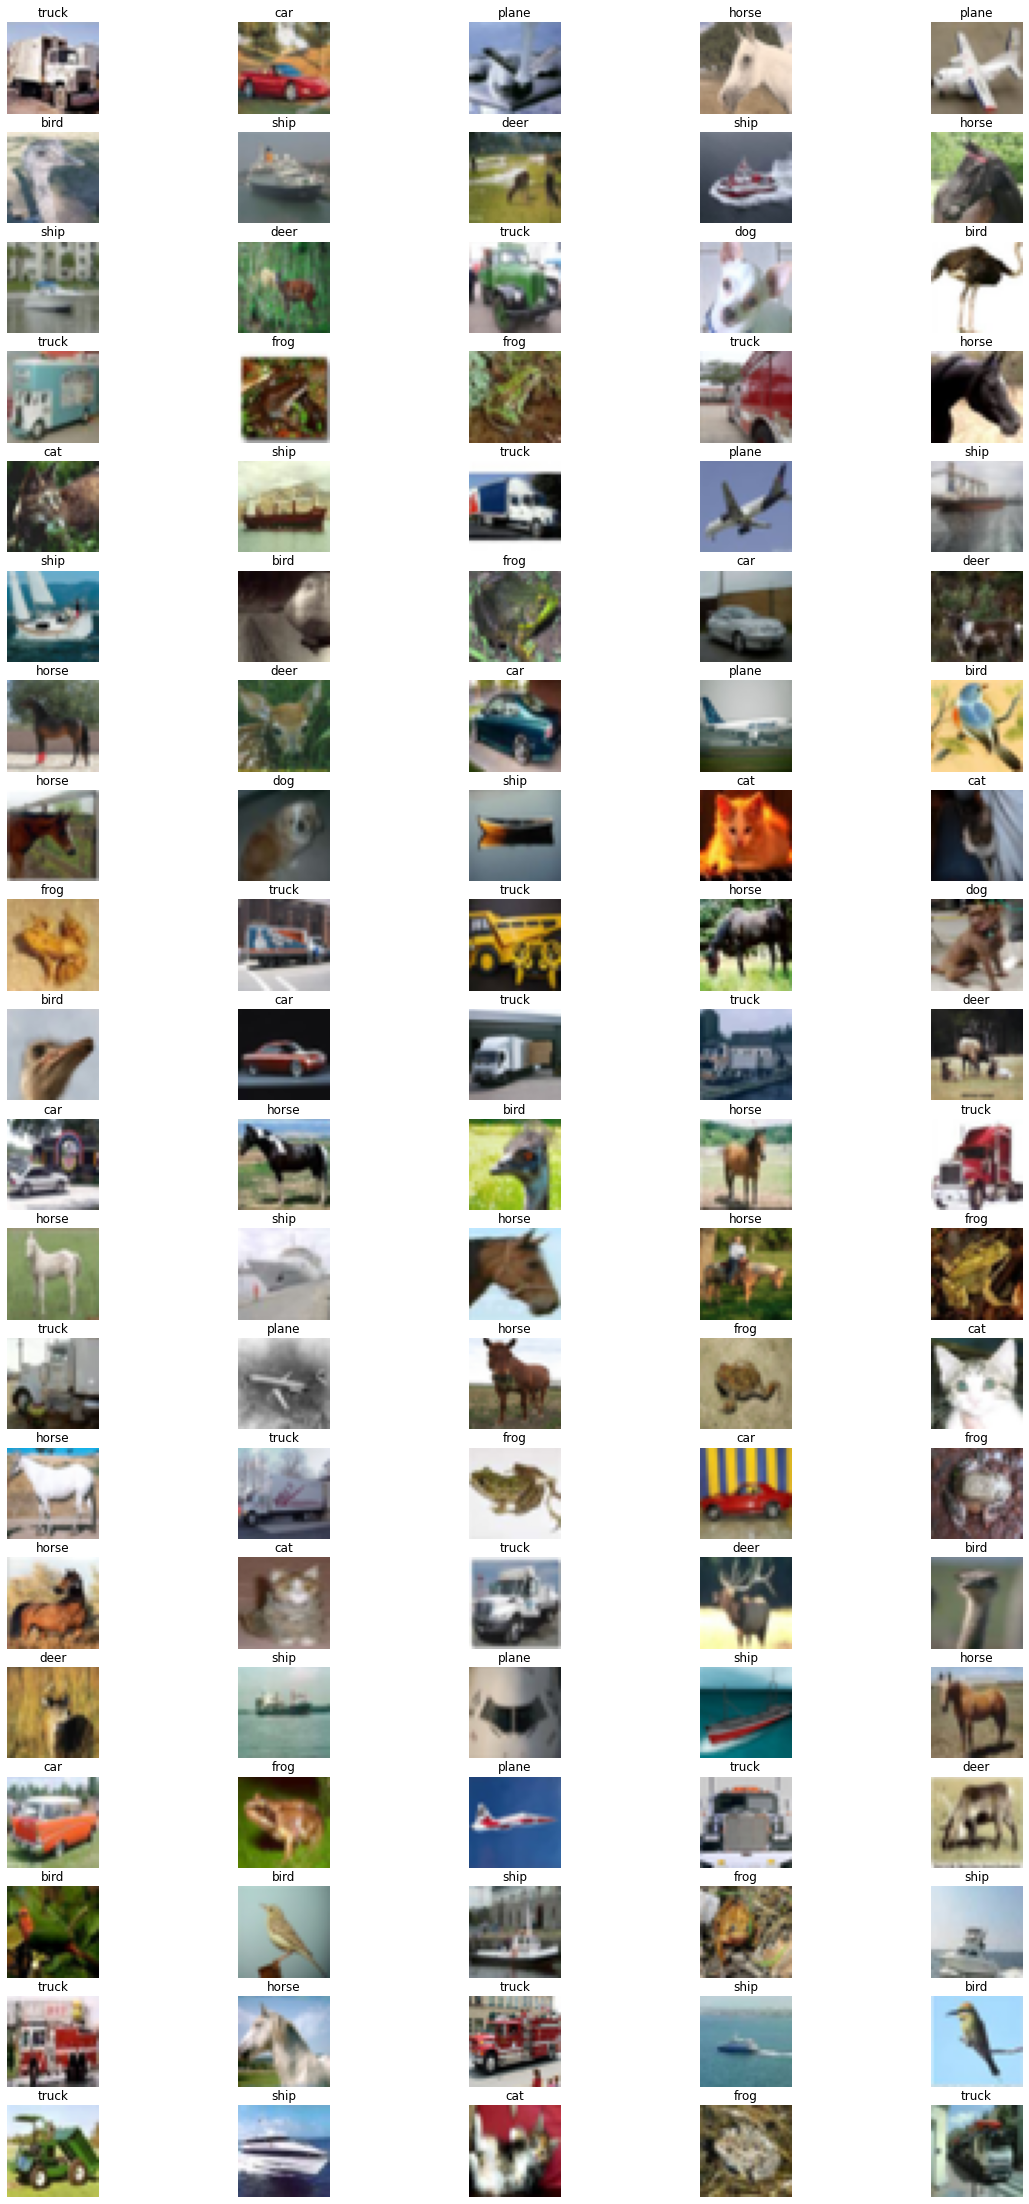

In [93]:
num_images = 5
plt.figure(figsize=(20, 40))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(min(num_images, len(clusters[c]))):
        image_idx = cluster_instances[j][0]
        img = trainloader.dataset[image_idx]['image']
        label = trainloader.dataset[image_idx]['label']
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(img.permute(1,2,0)*0.5+0.5)
        plt.title(classes[label])
        
        plt.axis("off")
        position += 1
        if j==len(clusters[c])-1 and len(clusters[c])<num_images :
            position += num_images-len(clusters[c])

In [94]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][trainloader.dataset[i]['label']] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")

cluster 0 label is: deer  -  accuracy: 13.73 %
cluster 1 label is: deer  -  accuracy: 12.5 %
cluster 2 label is: truck  -  accuracy: 12.25 %
cluster 3 label is: deer  -  accuracy: 12.68 %
cluster 4 label is: plane  -  accuracy: 12.64 %
cluster 5 label is: frog  -  accuracy: 13.38 %
cluster 6 label is: deer  -  accuracy: 12.22 %
cluster 7 label is: car  -  accuracy: 11.84 %
cluster 8 label is: cat  -  accuracy: 13.18 %
cluster 9 label is: plane  -  accuracy: 12.09 %
cluster 10 label is: deer  -  accuracy: 13.03 %
cluster 11 label is: frog  -  accuracy: 12.02 %
cluster 12 label is: plane  -  accuracy: 10.06 %
cluster 13 label is: bird  -  accuracy: 11.96 %
cluster 14 label is: dog  -  accuracy: 12.08 %
cluster 15 label is: frog  -  accuracy: 12.45 %
cluster 16 label is: bird  -  accuracy: 12.25 %
cluster 17 label is: ship  -  accuracy: 11.96 %
cluster 18 label is: truck  -  accuracy: 11.58 %
cluster 19 label is: plane  -  accuracy: 12.4 %
